In [1]:
from pathlib import Path
import json, pandas as pd
ROOT = Path(r"E:/FYP")
summary = json.loads((ROOT/"models/agent1_validation_summary.json").read_text())
per_house = pd.read_csv(ROOT/"data/processed/agent1_validation_per_house.csv")
summary, per_house.head(12)

({'PV_model_MAE_kW': 0.12428202819699352,
  'PV_base_MAE_kW': 0.12772916449270602,
  'PV_model_MAPE_%': 55.49983282897717,
  'PV_base_MAPE_%': 60.41682970580625,
  'PV_model_sMAPE_%': 45.663927163884225,
  'PV_base_sMAPE_%': 56.89784784905909,
  'PV_points_used': 12543,
  'Load_model_MAE_kW': 0.2762196314151085,
  'Load_base_MAE_kW': 0.29828804026050915,
  'Load_model_MAPE_%': 71.01220223052562,
  'Load_base_MAPE_%': nan,
  'Load_model_sMAPE_%': 49.52479841236592,
  'Load_base_sMAPE_%': 51.23977898935475,
  'Load_points_used': 27062},
    house_id  pv_model_mae  pv_base_mae  pv_model_sMAPE_%  pv_base_sMAPE_%  \
 0         1      0.111683     0.123307         41.959112        55.849186   
 1         2      0.144720     0.148619         47.894888        59.700676   
 2         3      0.113425     0.125288         43.259390        58.142356   
 3         4      0.128326     0.124722         48.584932        58.130461   
 4         5      0.129500     0.132220         49.396773        63.4

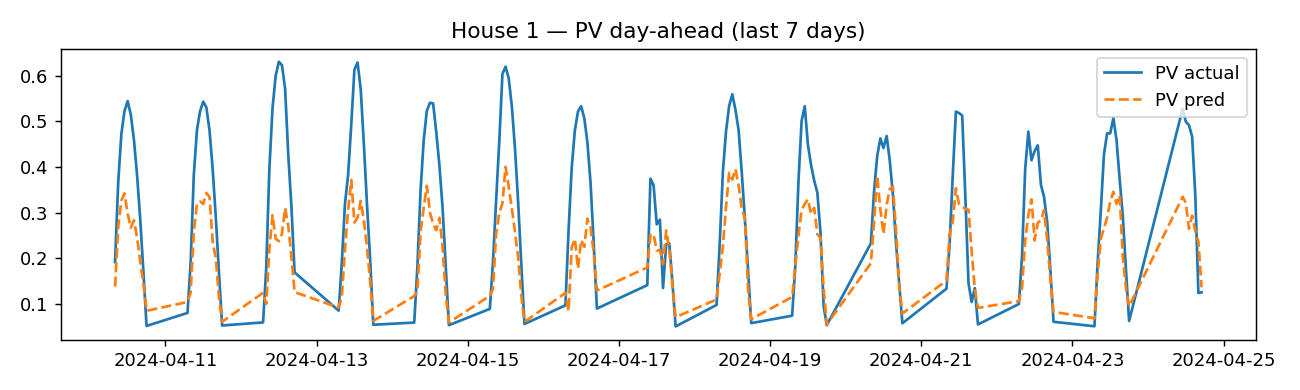

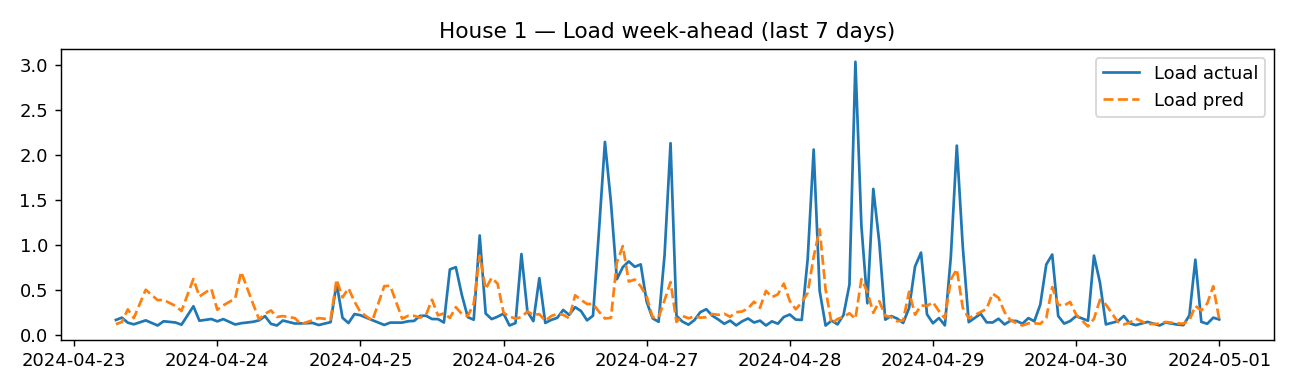

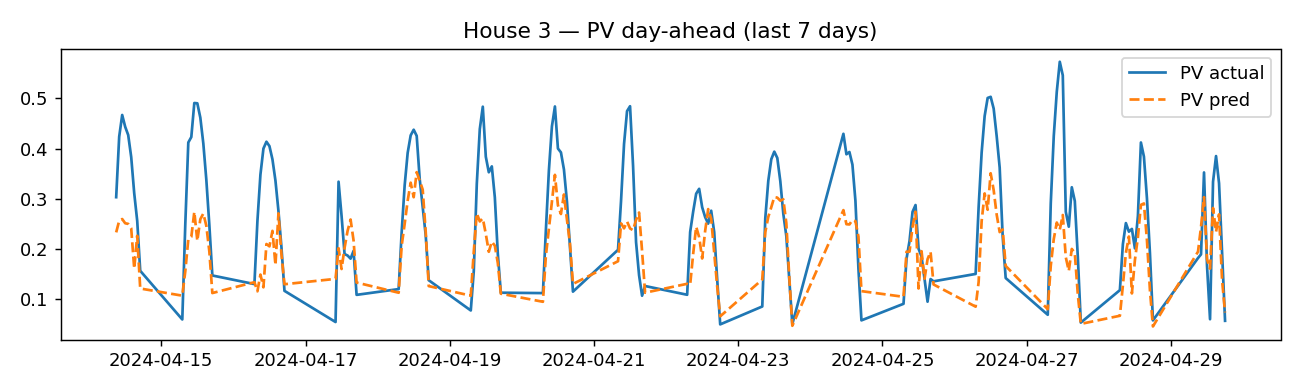

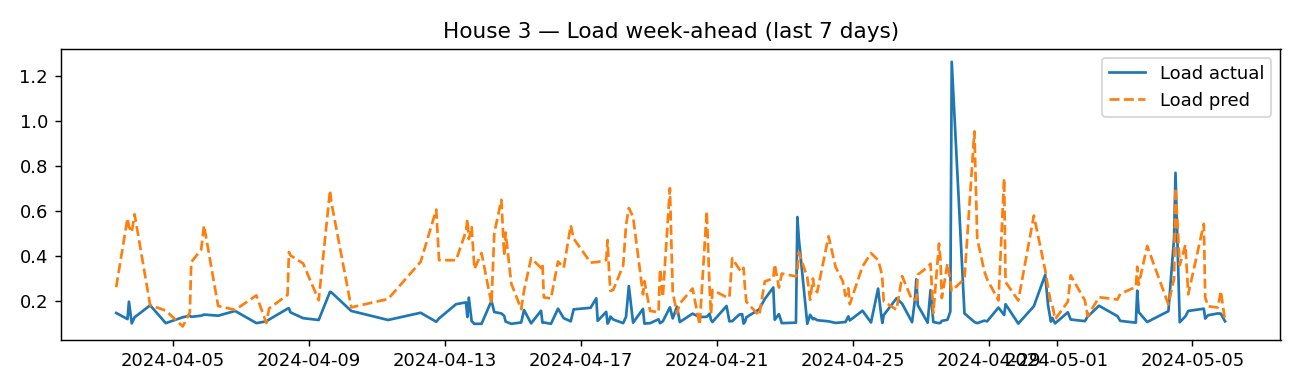

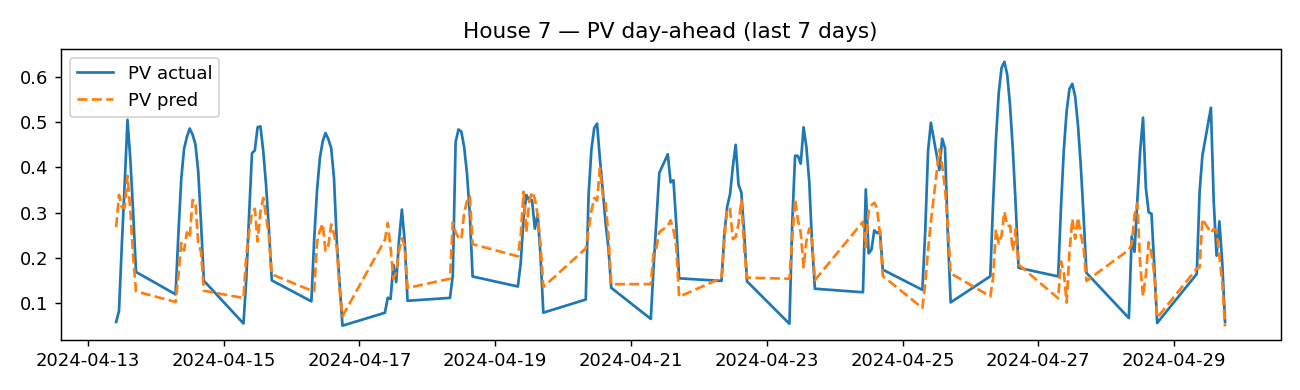

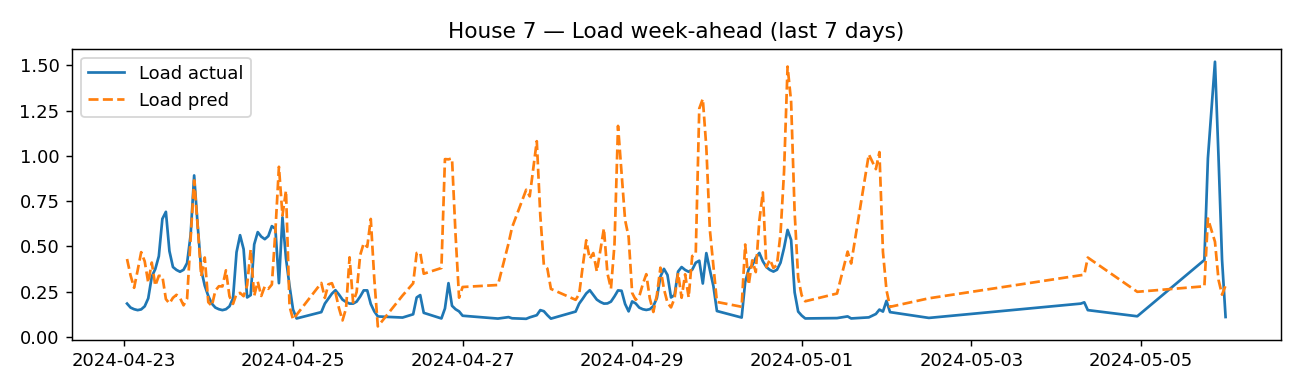

In [2]:
from IPython.display import Image, display
for hid in [1,3,7]:  # pick any 2-3 houses
    display(Image(filename=f"E:/FYP/reports/house_{hid:02d}_pv_last_week.png"))
    display(Image(filename=f"E:/FYP/reports/house_{hid:02d}_load_last_week.png"))


In [1]:
from pathlib import Path
import pandas as pd, numpy as np

ROOT = Path(r"E:/FYP")
PROC = ROOT / "data/processed"

# load predictions (aligned to target time)
pred = pd.read_csv(PROC/"agent1_predictions_aligned.csv",
                   parse_dates=["pv_for_time","load_for_time"])
# hourly actuals from 15-min data
raw = pd.read_csv(PROC/"all_houses_15min.csv", parse_dates=["timestamp"])
hourly = (raw.set_index("timestamp")
            .groupby("house_id").resample("1h")
            .agg({"pv_kw":"mean","load_kw":"mean"}).reset_index())

# PV join (daylight only)
pv = (pred[["house_id","pv_for_time","pv_nextday_kw_pred"]]
        .rename(columns={"pv_for_time":"target_time","pv_nextday_kw_pred":"pred"})
        .merge(hourly.rename(columns={"timestamp":"target_time","pv_kw":"actual"}),
               on=["house_id","target_time"], how="left"))
pv = pv[pv["actual"] >= 0.05].dropna(subset=["actual","pred"])

# Load join (ignore near-idle)
ld = (pred[["house_id","load_for_time","load_nextweek_kw_pred"]]
        .rename(columns={"load_for_time":"target_time","load_nextweek_kw_pred":"pred"})
        .merge(hourly.rename(columns={"timestamp":"target_time","load_kw":"actual"}),
               on=["house_id","target_time"], how="left"))
ld = ld[ld["actual"] >= 0.10].dropna(subset=["actual","pred"])

def smape(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    denom = (np.abs(y) + np.abs(yhat)) / 2.0
    m = denom > 1e-6
    return float(np.mean(np.abs(y[m]-yhat[m]) / denom[m]) * 100)

def hit_rate(y, yhat, tol):
    err = np.abs(np.asarray(y) - np.asarray(yhat))
    return float((err <= tol).mean() * 100)

PV_TOL, LOAD_TOL = 0.20, 0.30  # kW

pv_accuracy = 100 - smape(pv["actual"], pv["pred"])
pv_hit      = hit_rate(pv["actual"], pv["pred"], PV_TOL)
load_accuracy = 100 - smape(ld["actual"], ld["pred"])
load_hit      = hit_rate(ld["actual"], ld["pred"], LOAD_TOL)

pv_points, load_points = len(pv), len(ld)

pv_accuracy, pv_hit, load_accuracy, load_hit, pv_points, load_points


(54.336072836115775,
 79.21549868452523,
 50.47520158763408,
 72.45214692188308,
 12543,
 27062)

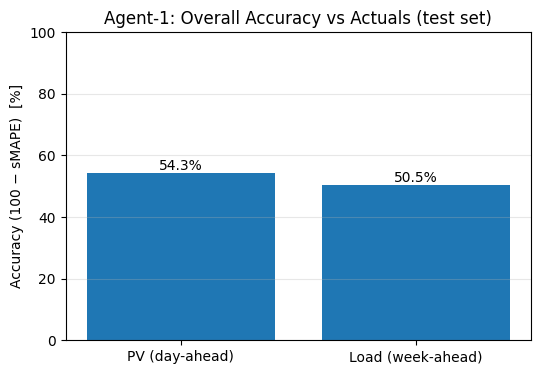

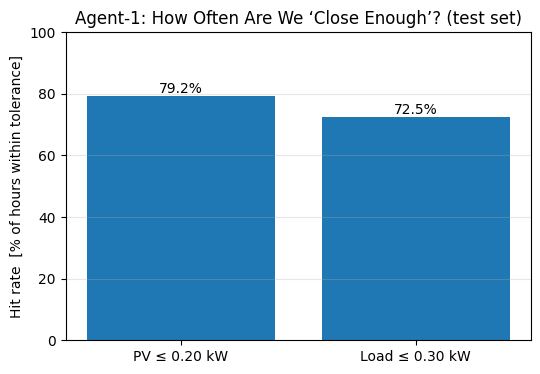

In [2]:
import matplotlib.pyplot as plt

# 1) “accuracy” bars (100 − sMAPE)
plt.figure(figsize=(6,4))
labels = ["PV (day-ahead)", "Load (week-ahead)"]
vals = [pv_accuracy, load_accuracy]
plt.bar(labels, vals)
for i,v in enumerate(vals):
    plt.text(i, v, f"{v:.1f}%", ha="center", va="bottom")
plt.ylim(0, 100)
plt.ylabel("Accuracy (100 − sMAPE)  [%]")
plt.title("Agent-1: Overall Accuracy vs Actuals (test set)")
plt.grid(axis="y", alpha=0.3)
plt.show()

# 2) hit-rate bars (within tolerance)
plt.figure(figsize=(6,4))
labels = [f"PV ≤ {PV_TOL:.2f} kW", f"Load ≤ {LOAD_TOL:.2f} kW"]
vals = [pv_hit, load_hit]
plt.bar(labels, vals)
for i,v in enumerate(vals):
    plt.text(i, v, f"{v:.1f}%", ha="center", va="bottom")
plt.ylim(0, 100)
plt.ylabel("Hit rate  [% of hours within tolerance]")
plt.title("Agent-1: How Often Are We ‘Close Enough’? (test set)")
plt.grid(axis="y", alpha=0.3)
plt.show()


# Agent-1 Accuracy — What does the % mean and how we compute it

**Headline metric we show:** `Accuracy (%) = 100 − sMAPE`  
This answers: *“How close are the model’s predictions to the actual data on the held-out test set?”*

---

## How we compute it (for PV day-ahead and Load week-ahead)

1. **Join predictions with actuals at the *target* time**
   - Read `data/processed/agent1_predictions_aligned.csv` (has `pv_for_time`, `load_for_time`, and predictions).
   - Build hourly actuals from `data/processed/all_houses_15min.csv` (15-min → hourly mean).
   - Merge on `["house_id", "target_time"]`.

2. **Keep only meaningful hours** (to avoid division by ~0 in percentage metrics)
   - **PV:** daylight only → keep rows where `pv_actual ≥ 0.05 kW`.
   - **Load:** ignore near-idle → keep rows where `load_actual ≥ 0.10 kW`.

3. **Compute sMAPE, then convert to “accuracy”**
   
   > Notebook / Math-enabled Markdown:
   >
   > $$
   > \text{sMAPE}=\frac{1}{N}\sum_{i=1}^{N}\frac{\lvert y_i-\hat y_i\rvert}{\left(\lvert y_i\rvert+\lvert\hat y_i\rvert\right)/2}\times 100\%
   > $$
   >
   > **Accuracy** $= 100 - \text{sMAPE}$

   > Plain-text fallback (if math doesn’t render):  
   > `sMAPE = mean( |y − ŷ| / ((|y| + |ŷ|)/2) ) * 100` → `Accuracy = 100 − sMAPE`

---

## What the numbers mean (example from our latest run)

- **PV accuracy:** **54.3%** → average relative agreement between forecast and actual PV over daylight test hours is 54.3% (avg sMAPE ≈ 45.7%).
- **Load accuracy:** **50.5%** → average relative agreement between forecast and actual load over non-idle test hours is 50.5% (avg sMAPE ≈ 49.5%).

These are computed entirely on **unseen test data**.

---

## Complementary “Hit-Rate” (operational view)

We also report a threshold-based accuracy that answers: *“How often are we ‘close enough’?”*

- **Definition:** `Hit rate (%) = share of hours with |error| ≤ tolerance`
- **Our tolerances:** PV ≤ **0.20 kW**, Load ≤ **0.30 kW**
- **Latest results:** PV **79.2%** within ±0.20 kW; Load **72.5%** within ±0.30 kW.

This connects cleanly to scheduling/trading decisions (e.g., offer sizing and battery safety margins).

---

## Why we use `100 − sMAPE` (and not plain MAPE)

- **Stable near zero:** PV at night and very low loads make MAPE explode; sMAPE remains bounded.
- **Bounded and interpretable:** sMAPE ∈ [0, 200], so `100 − sMAPE` maps to a 0–100% “accuracy” scale.
- **Fair comparison across houses and seasons:** scale-free and symmetric.

---

## Reproduce these numbers

Run in your venv from `E:/FYP`:

```powershell
python -m src.agent1_simple_accuracy
